In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
systole <- read_tsv("../../analysis/kaggle/predictions/prediction_vs_gt_systole.tsv")
diastole <- read_tsv("../../analysis/kaggle/predictions/prediction_vs_gt_diastole.tsv")


── Column specification ────────────────────────────────────────────────────────
cols(
  Id = col_character(),
  GroundTruth = col_double(),
  method = col_character(),
  prediction = col_double(),
  distance = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  Id = col_character(),
  GroundTruth = col_double(),
  method = col_character(),
  prediction = col_double(),
  distance = col_double()
)




In [3]:
ef <- systole %>%
    left_join(diastole, by=c("Id","method"), suffix=c(".sys",".dia")) %>%
    mutate(
        rel_dist.dia = distance.dia/GroundTruth.dia,
        rel_dist.sys = distance.sys/GroundTruth.sys,
        true_ef=(GroundTruth.dia-GroundTruth.sys)/GroundTruth.dia,
        pred_ef=(prediction.dia-prediction.sys)/prediction.dia, 
        distance.ef=true_ef-pred_ef,
        rel_dist.max = pmax(rel_dist.dia, rel_dist.sys),
        rel_dist.ef = distance.ef/true_ef) %>%
    replace_na(list(rel_dist.ef=1,distance.ef=1))

In [4]:
library("GGally")

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [5]:
theme_set(theme_minimal())
options(repr.plot.width = 8, repr.plot.res=200)

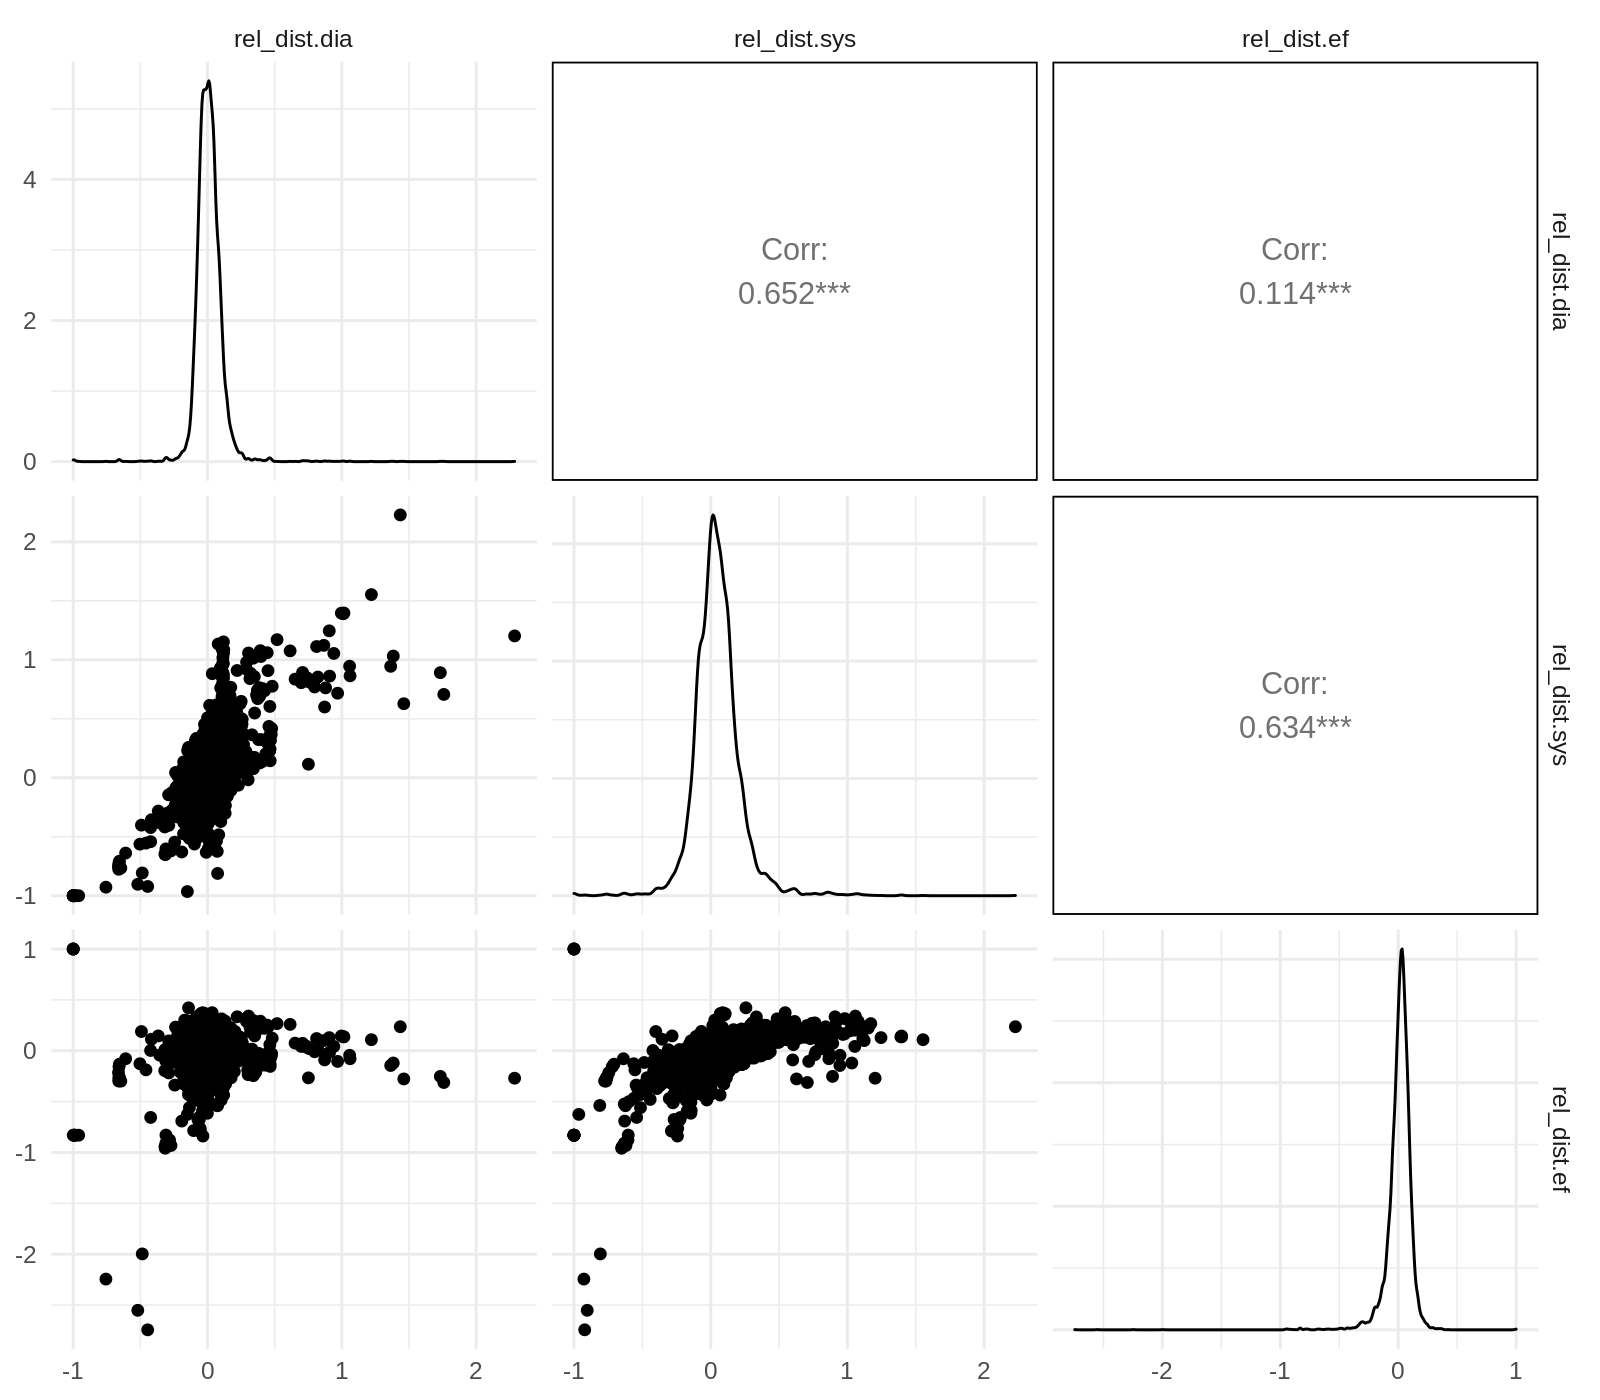

In [6]:
ggpairs(ef %>% filter(method!="UKBB") %>% select(contains("rel_dist"),-rel_dist.max))

In [7]:
ef %>% select(method) %>% unique

method
<chr>
UKBB
r34_p05_s128
r50_p05_s256
v16_p05_s256
r34_p05_s256
r34_p05_s256_focal
r34_p05_s256_dice
r34_p10_s256
r34_p05_s256_extremeTfms


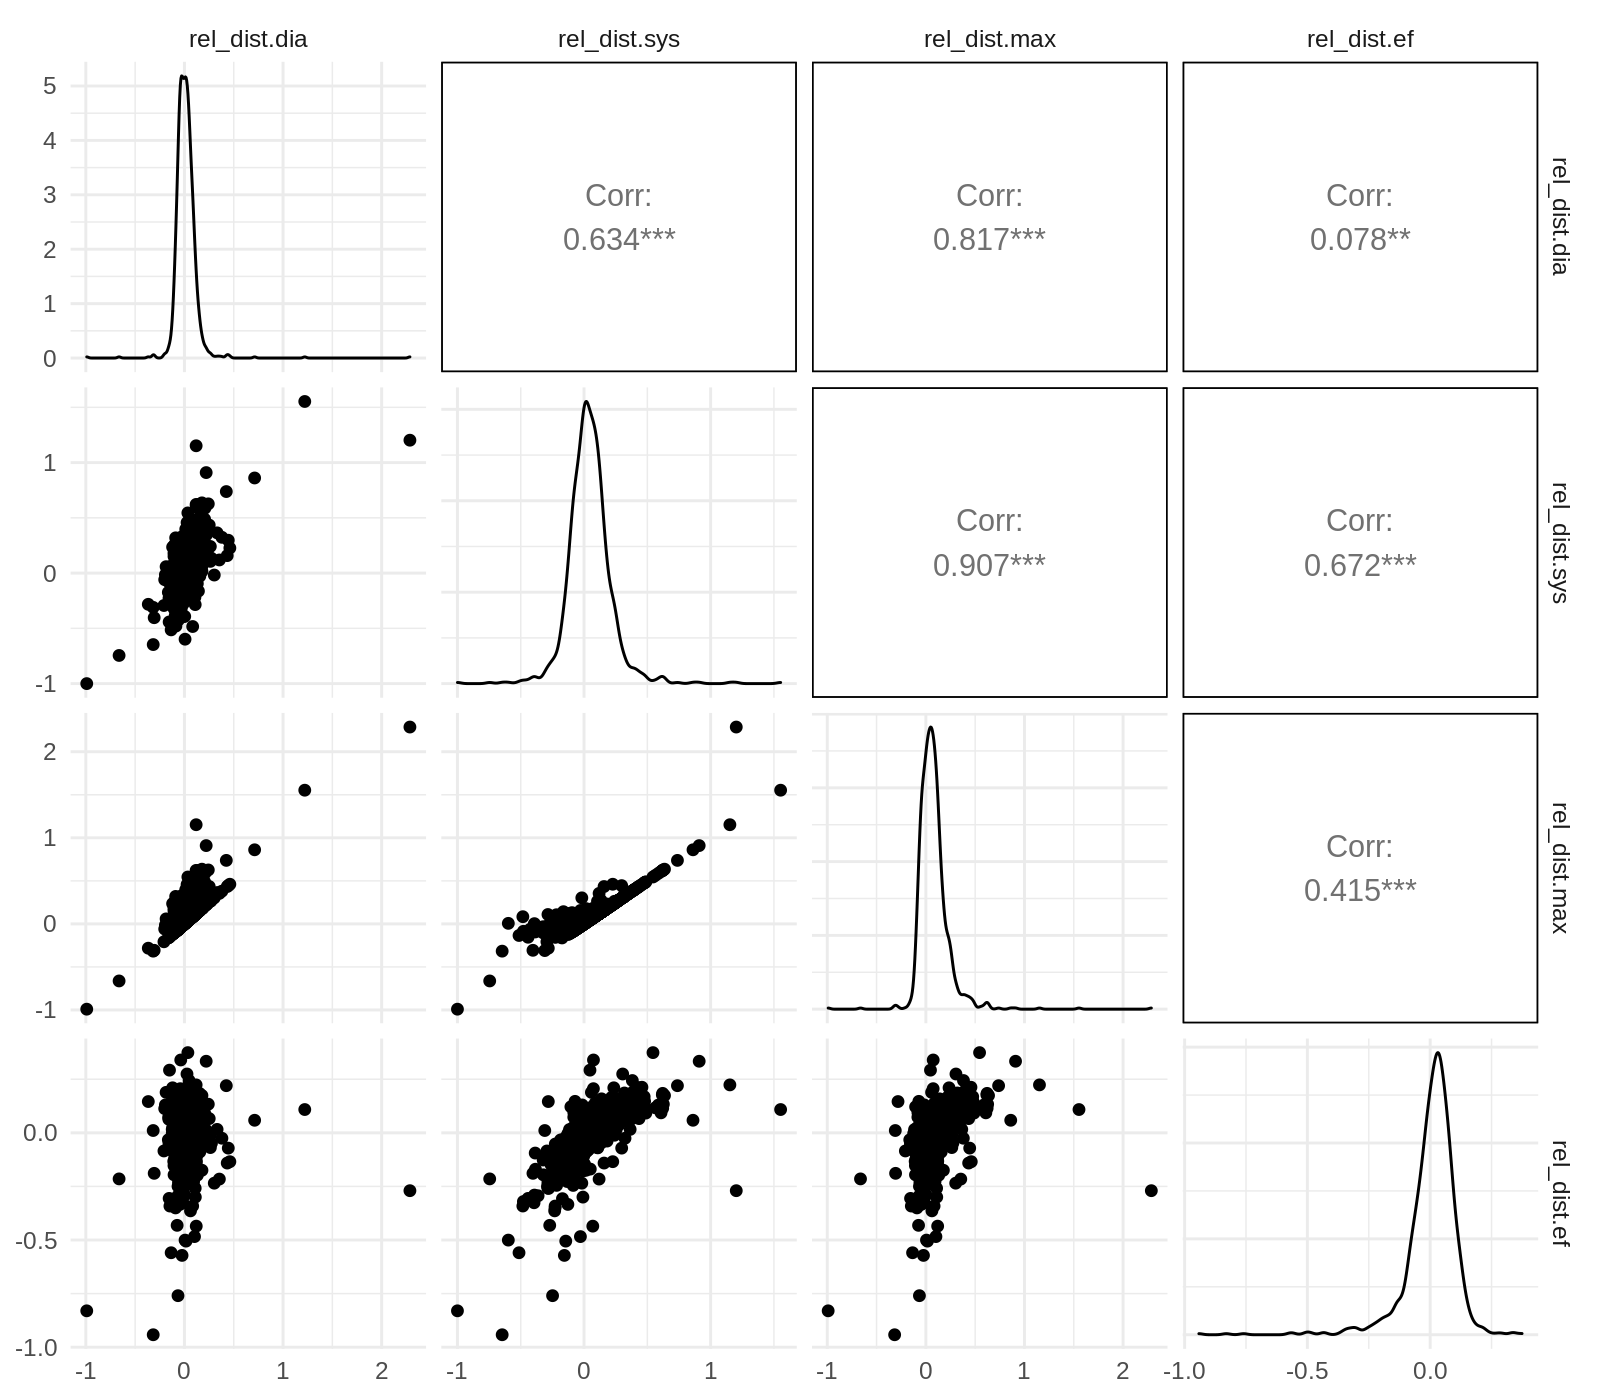

In [8]:
ggpairs(ef %>% filter(method=="r34_p05_s256_extremeTfms") %>% select(contains("rel_dist")))

`geom_smooth()` using formula 'y ~ x'



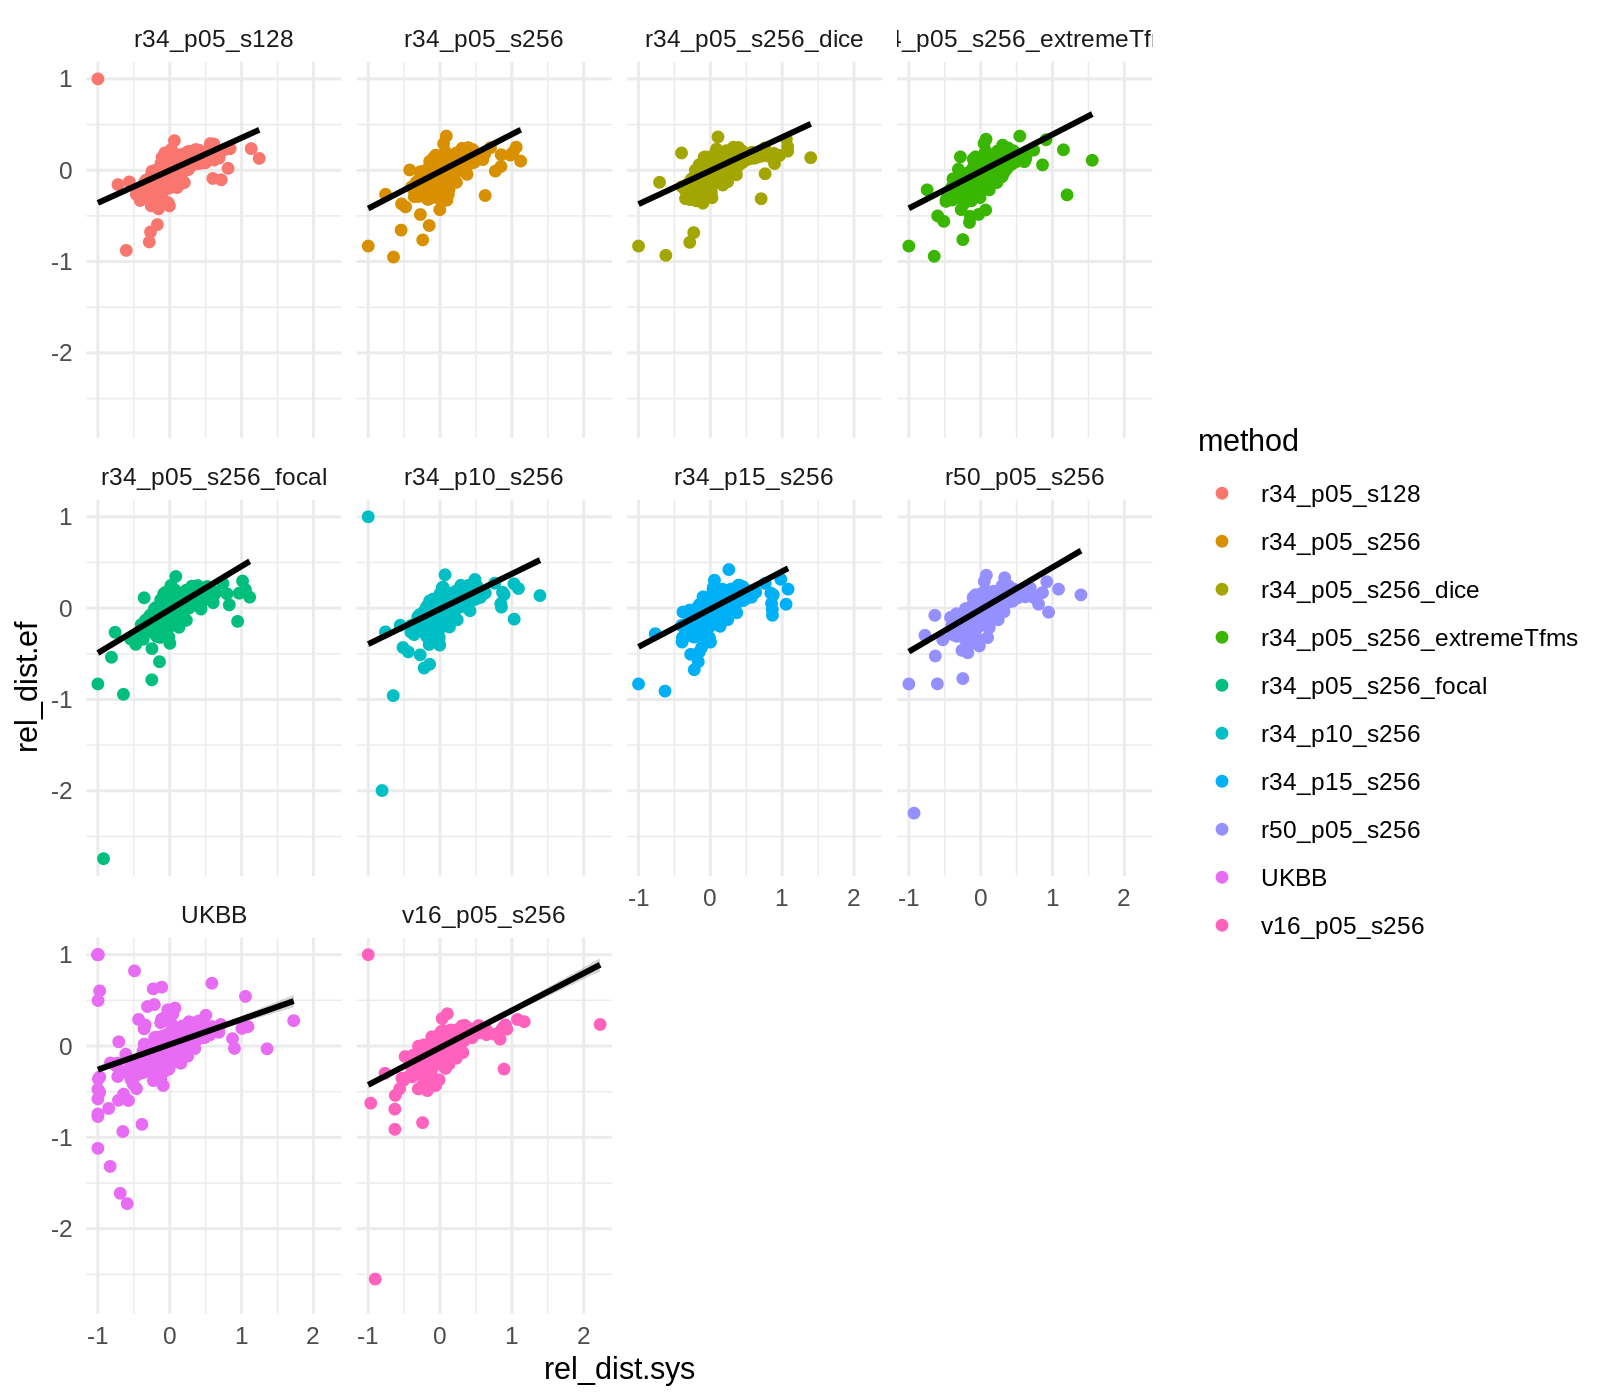

In [9]:
ggplot(ef, aes(rel_dist.sys, rel_dist.ef, color=method)) +
    geom_point() +
    facet_wrap(~ method) +
    geom_smooth(color="black",method="lm")

Warning message:
“Removed 45 rows containing missing values (geom_point).”


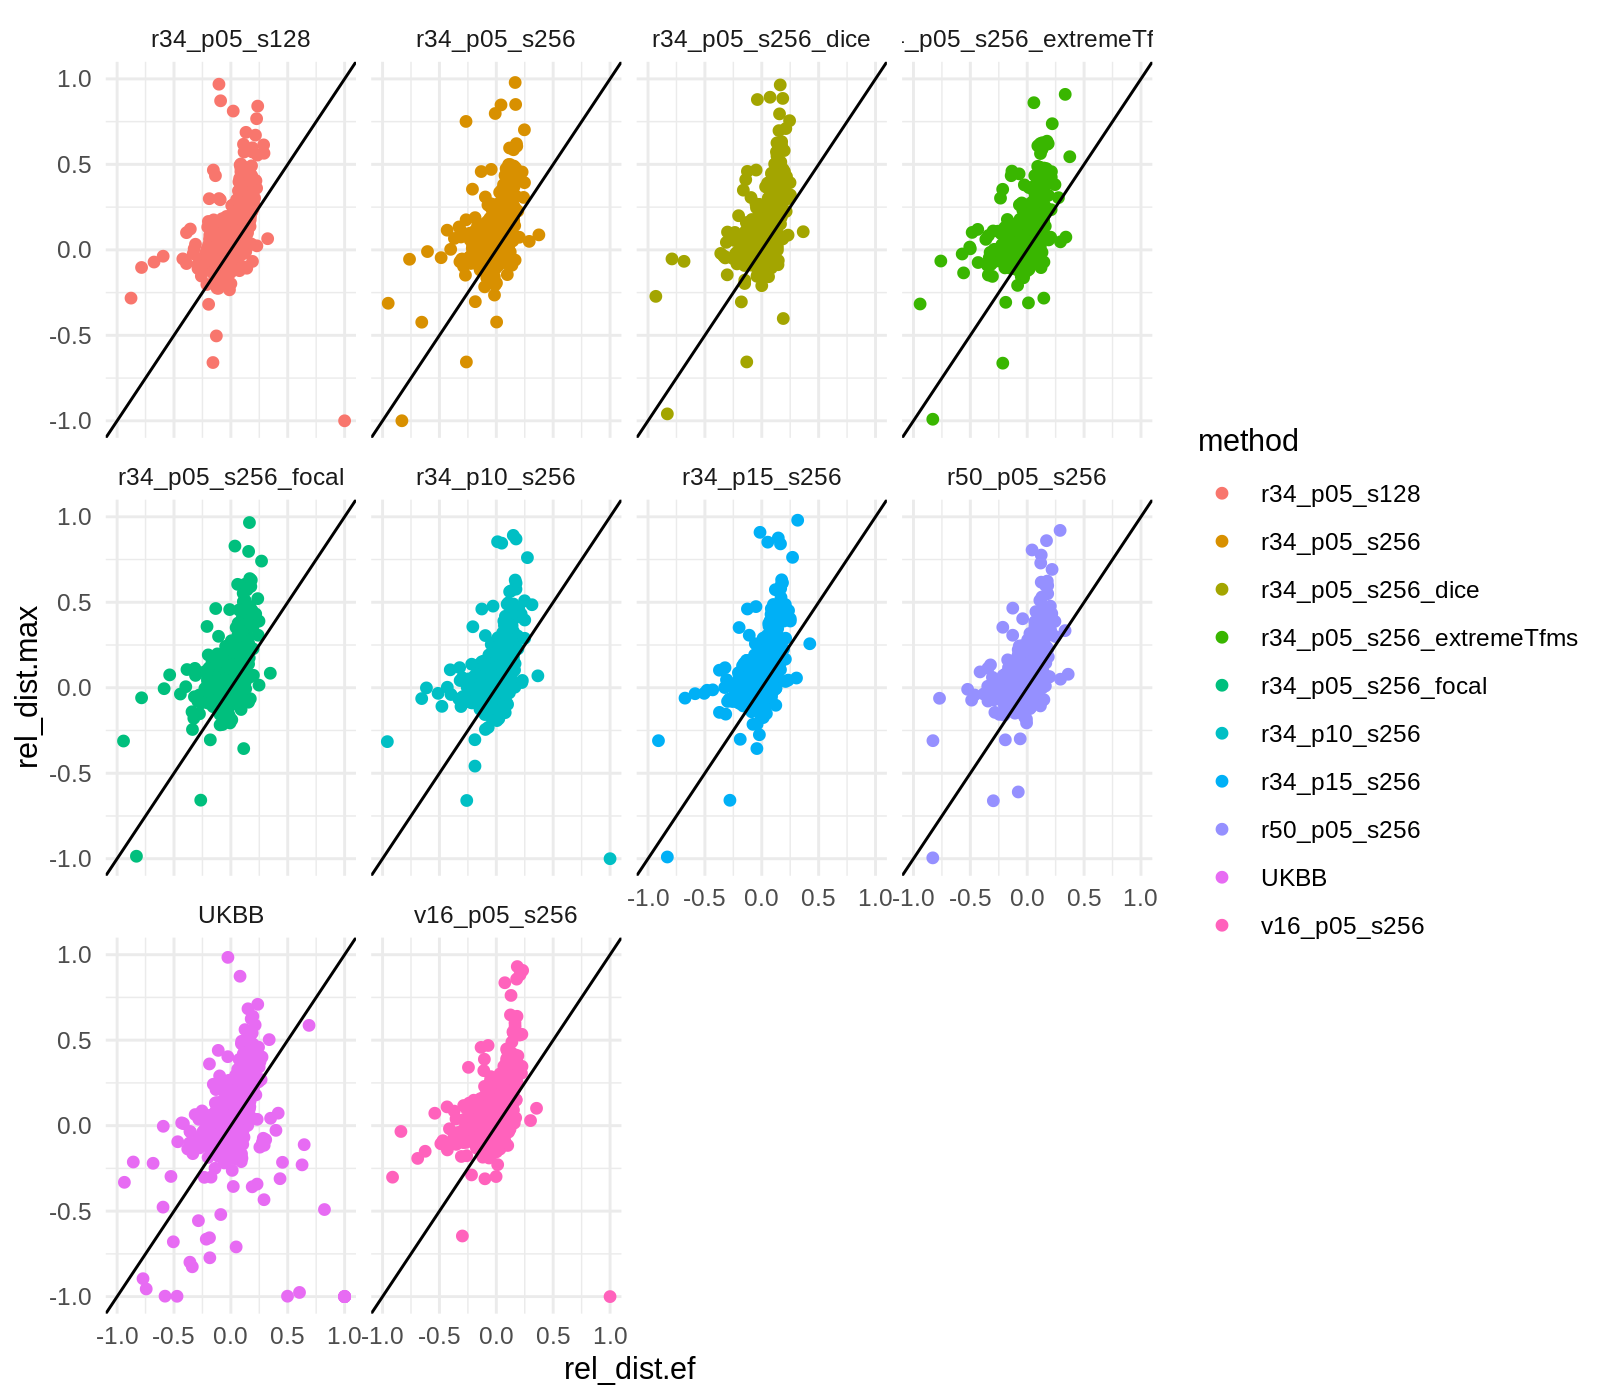

In [10]:
ggplot(ef, aes(rel_dist.ef, rel_dist.max, color=method)) + geom_point() + facet_wrap(~ method) + ylim(-1,1) + xlim(-1,1) + geom_abline()

In [11]:
ef %>%
    group_by(method) %>%
    mutate(good_ef_bad_vol=abs(rel_dist.ef) <= .1 & abs(rel_dist.max) > .2) %>%
    count(good_ef_bad_vol) %>%
    pivot_wider(names_from = good_ef_bad_vol,values_from = n) %>%
    transmute(good_ef_bad_vol_perc = round(100*`TRUE`/(`TRUE`+`FALSE`),1))

method,good_ef_bad_vol_perc
<chr>,<dbl>
r34_p05_s128,6.1
r34_p05_s256,7.7
r34_p05_s256_dice,9.2
r34_p05_s256_extremeTfms,7.4
r34_p05_s256_focal,6.8
r34_p10_s256,7.3
r34_p15_s256,7.0
r50_p05_s256,7.0
UKBB,6.3


In [12]:
cor.test(ef$rel_dist.max, ef$rel_dist.ef)


	Pearson's product-moment correlation

data:  ef$rel_dist.max and ef$rel_dist.ef
t = 45.395, df = 11488, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3743777 0.4053873
sample estimates:
      cor 
0.3899931 


Warning message:
“Removed 10 rows containing missing values (geom_point).”


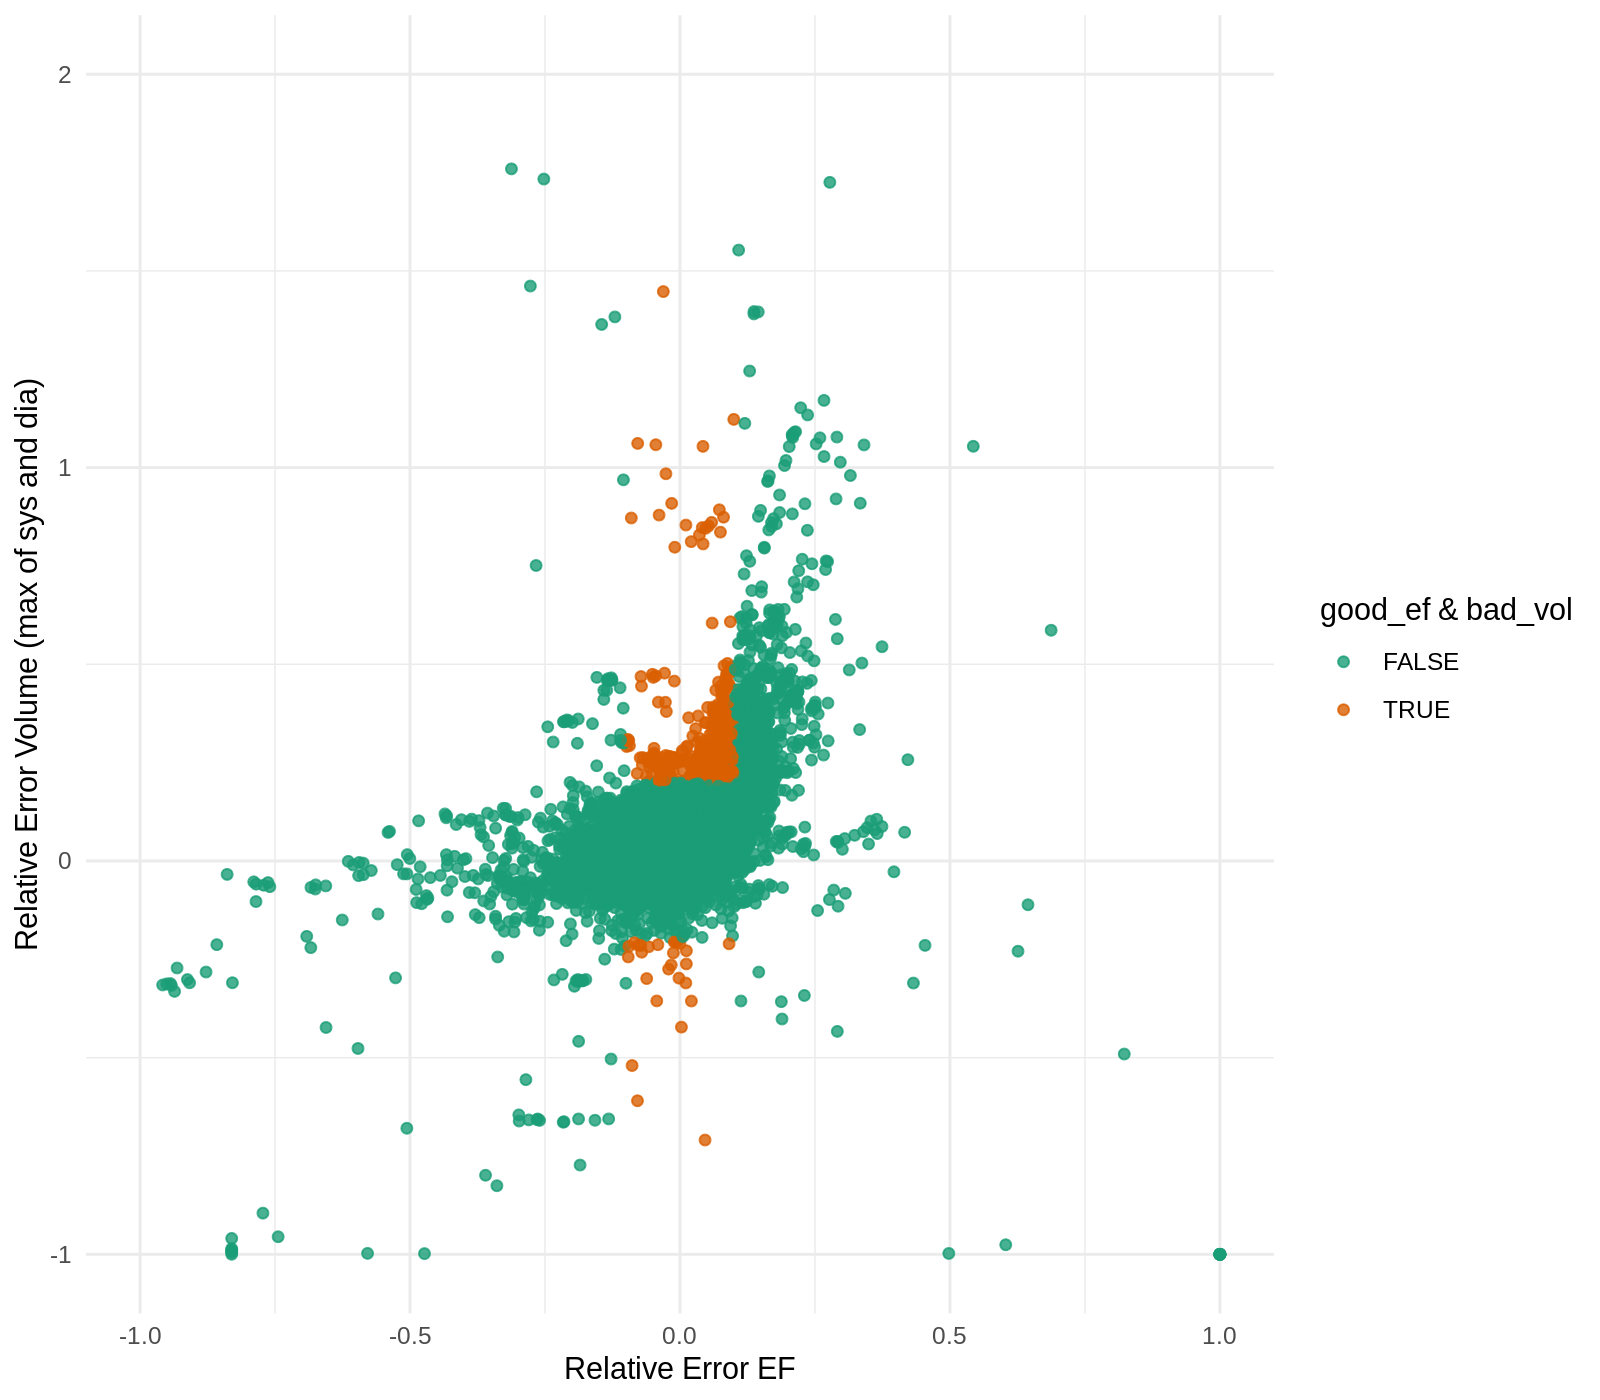

In [13]:
ggplot(
    ef %>% mutate(good_ef = abs(rel_dist.ef)<=.1, bad_vol=abs(rel_dist.max)>.2),
    aes(rel_dist.ef, rel_dist.max, color=good_ef&bad_vol)
    ) +
    scale_color_brewer(palette = "Dark2") +
    geom_point(alpha=.8) +
    xlim(-1,1) +
    ylim(-1,2) +
    xlab("Relative Error EF") +
    ylab("Relative Error Volume (max of sys and dia)")

In [14]:
# Rank networks by max volume instead of EF

In [15]:
round_to = 4
ef %>% group_by(method) %>%
    mutate(distance=abs(rel_dist.max)) %>%
    summarize(mean=mean(distance),sd=sd(distance),median=median(distance),iqr=IQR(distance),mad=mad(distance)) %>%
    arrange(mean) %>%
    mutate_if(is.numeric, round, round_to) %>%
    mutate_if(is.numeric, `*`, 100) %>% knitr::kable()



|method                   |  mean|    sd| median|   iqr|  mad|
|:------------------------|-----:|-----:|------:|-----:|----:|
|v16_p05_s256             | 10.58| 14.44|   6.92|  9.24| 6.16|
|r34_p05_s128             | 10.85| 12.61|   7.36| 10.13| 6.69|
|r50_p05_s256             | 10.85| 12.60|   7.36|  9.76| 6.76|
|r34_p05_s256_extremeTfms | 10.92| 13.83|   7.45|  9.68| 6.69|
|r34_p15_s256             | 10.97| 12.48|   7.59|  9.97| 6.94|
|r34_p10_s256             | 11.02| 13.05|   7.49| 10.10| 6.88|
|r34_p05_s256             | 11.04| 12.96|   7.43| 10.40| 6.90|
|r34_p05_s256_focal       | 11.05| 12.79|   7.32| 10.32| 6.81|
|r34_p05_s256_dice        | 12.99| 14.86|   8.64| 13.47| 8.48|
|UKBB                     | 13.24| 17.02|   8.43| 11.58| 7.70|

In [16]:
round_to = 4
ef %>% group_by(method) %>%
    mutate(distance=abs(distance.ef)) %>%
    summarize(mean=mean(distance),sd=sd(distance),median=median(distance),iqr=IQR(distance),mad=mad(distance)) %>%
    arrange(mean) %>%
    mutate_if(is.numeric, round, round_to) %>%
    mutate_if(is.numeric, `*`, 100)

method,mean,sd,median,iqr,mad
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
r34_p05_s256,3.64,3.38,2.87,3.72,2.66
r50_p05_s256,3.71,3.73,2.79,3.70,2.50
r34_p15_s256,3.73,3.38,2.91,3.72,2.55
r34_p05_s256_focal,3.75,3.90,2.86,3.80,2.61
r34_p10_s256,3.77,4.44,2.89,3.76,2.66
r34_p05_s256_extremeTfms,3.78,3.59,2.89,3.64,2.55
r34_p05_s128,3.90,4.26,3.05,3.86,2.70
r34_p05_s256_dice,3.93,3.43,3.07,3.91,2.73
v16_p05_s256,4.06,4.94,3.02,3.87,2.66
